initial accuracy: 0.1442
epoch 1 accuracy: 0.9532
epoch 2 accuracy: 0.9691


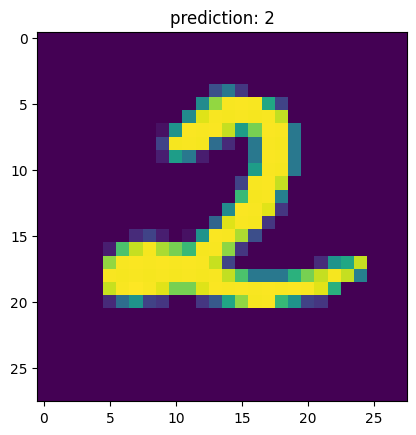

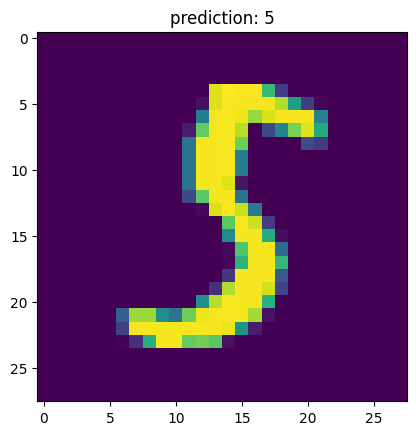

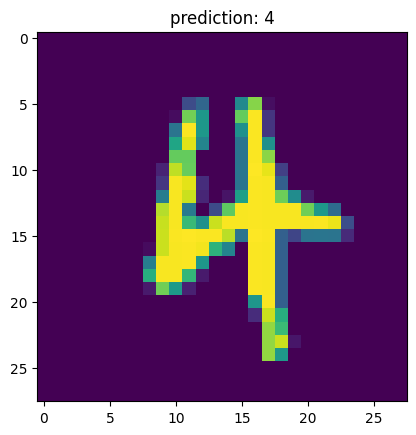

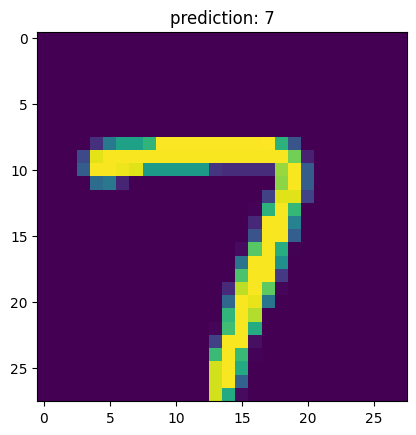

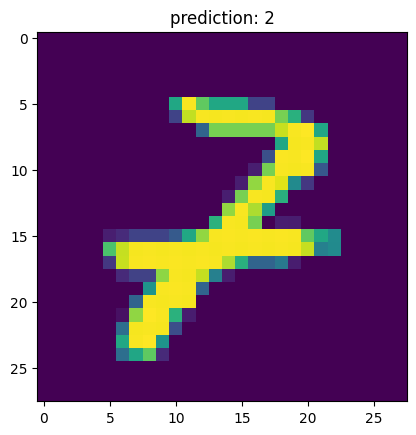

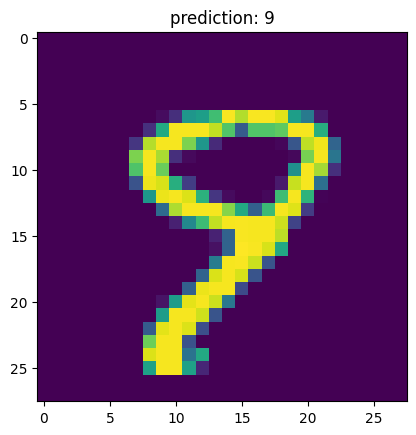

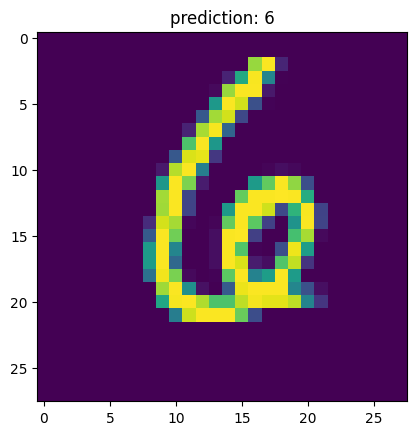

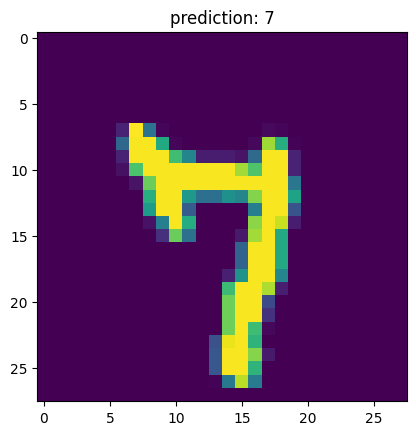

In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        # log_softmax提高稳定性，在softmax外套了一层对数，加快运算速度
        # dim=0: row; dim=1: column(conpare to axis)
        x = torch.nn.functional.log_softmax(self.fc3(x), dim=1)
        return x


def get_data_loader(is_train):
    # 数据转换类型tensor
    tensor = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
    data_set = MNIST("data", is_train, transform=tensor, download=True)
    return DataLoader(data_set, batch_size=64, shuffle=True)


def evaluate(test_data, net):
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        # 从测试集中按批次取出数据
        for (img_data, label_list) in test_data:
            (img_data, label_list) = (img_data.to(device), label_list.to(device))
            # 计算神经网络预测值
            outputs = net.forward(img_data.view(-1, 28*28))
            for i, output in enumerate(outputs):
                # torch.argmax:返回最大值维度的index
                if torch.argmax(output) == label_list[i]:
                    n_correct += 1
                n_total += 1
    return n_correct / n_total


def main():     
    train_data = get_data_loader(is_train=True)
    test_data = get_data_loader(is_train=False)
    
    net = Net()
    net.to(device)
    print("initial accuracy:", evaluate(test_data, net))
    # params=net.parameters():需要优化的参数 lr:learning rate
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0017)
    # 在一个数据集上反复训练神经网络，可提高数据集的利用率
    repeat_Num = 2
    for epoch in range(repeat_Num):
        for (img_data, label) in train_data:
            (img_data, label) = (img_data.to(device), label.to(device))
            # 初始化
            net.zero_grad()
            # 正向传播
            predict = net.forward(img_data.view(-1, 28*28))
            # 计算差值
            # nll_loss,对数损失函数，匹配前面的log_softmax
            # 将log_softmax处理后的值按标签取出，去负号，求均值
            loss = torch.nn.functional.nll_loss(predict, label)
            # 反向误差传播
            loss.backward()
            # 优化网络参数
            optimizer.step()
        print("epoch", epoch + 1, "accuracy:", evaluate(test_data, net))
    for (n, (x,_)) in enumerate(test_data):
        if n > 7:
            break
        predict = torch.argmax(net.forward(x[0].to(device).view(-1, 28*28)))
        plt.figure(n)
        plt.imshow(x[0].cpu().view(28, 28))
        plt.title("prediction: " + str(int(predict)))
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    main()

